In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys, os, pickle

from tqdm.notebook import tqdm
from datetime import timedelta

if os.getcwd()[-4:] == "code":
    os.chdir('../')

icu = './data/mimic-iv-2.2-parquet/icu/'
hosp = './data/mimic-iv-2.2-parquet/hosp/'

# Import data

In [2]:
labevents     = pd.read_parquet(hosp+'labevents.parquet')
d_labitems    = pd.read_parquet(hosp+'d_labitems.parquet')

patients      = pd.read_parquet(hosp+'patients.parquet')
admissions    = pd.read_parquet(hosp+'admissions.parquet')

diagnoses_icd = pd.read_parquet(hosp+'diagnoses_icd.parquet')
microbiology  = pd.read_parquet(hosp+'microbiologyevents.parquet')
prescriptions = pd.read_parquet(hosp+'prescriptions.parquet')

In [3]:
chartevents     = pd.read_parquet(icu+'chartevents.parquet')
d_items         = pd.read_parquet(icu+'d_items.parquet')
inputevents     = pd.read_parquet(icu+'inputevents.parquet')
procedureevents = pd.read_parquet(icu+'procedureevents.parquet')
icustays        = pd.read_parquet(icu+'icustays.parquet')

# SCr

In [4]:
if not os.path.isfile("./data/data_modi/chartevents_SCr.parquet"):
    chartevents_SCr = chartevents[chartevents['itemid'].isin([220615])]
    chartevents_SCr = chartevents_SCr[(chartevents_SCr['valuenum'] <= 40) & (chartevents_SCr['valuenum'] > 0)]
    chartevents_SCr.reset_index(drop=True, inplace=True)
    #chartevents_SCr.to_parquet('./data/data_modi/chartevents_SCr.parquet')
else:
    chartevents_SCr = pd.read_parquet("./data/data_modi/chartevents_SCr.parquet")

In [5]:
chartevents_SCr = chartevents_SCr[['subject_id','hadm_id','stay_id','charttime','valuenum']]
chartevents_SCr['charttime'] = pd.to_datetime(chartevents_SCr['charttime'])
chartevents_SCr.sort_values(by=['stay_id','charttime'],inplace=True)

In [6]:
def baseline_sCr(icu_chartevents_sCr,icu_icustays,hosp_labevents) :
    icu_sCr_subject_id = icu_chartevents_sCr['subject_id'].unique()
    icu_sCr_stay_id = icu_chartevents_sCr['stay_id'].unique()

    icu_icustays_sCr = icu_icustays[icu_icustays['stay_id'].isin(icu_sCr_stay_id)]
    icu_icustays_sCr['intime'] = pd.to_datetime(icu_icustays_sCr['intime'])

    hosp_labevents_sCr = hosp_labevents[hosp_labevents['itemid'].isin([
    50912, # Creatinine, Blood, Chemistry
    52024, # Creatinine, Whole Blood, Blood, Chemistry
    52546  # Creatinine, Blood, Chemistry
    ])]

    hosp_labevents_sCr = hosp_labevents_sCr[['subject_id','hadm_id','charttime','valuenum']]
    hosp_labevents_sCr['charttime'] = pd.to_datetime(hosp_labevents_sCr['charttime'])

    baseline_sCr_list = []

    for i in tqdm(icu_sCr_subject_id) : 
        tmp_hosp_labevents_sCr = hosp_labevents_sCr[hosp_labevents_sCr['subject_id'] == i]
        for j in icu_icustays_sCr[icu_icustays_sCr['subject_id'] == i].stay_id : 
            tmp_icu_icustays_intime = icu_icustays_sCr[icu_icustays_sCr['stay_id'] == j].iloc[0]
            tmp_icu_icustays_intime_7days = tmp_icu_icustays_intime['intime'] - timedelta(days=7)
            tmp_icu_icustays_intime_1yr = tmp_icu_icustays_intime['intime'] - timedelta(days=365)

            baseline_sCr = 0
            
            tmp_hosp_labevents_sCr_list = tmp_hosp_labevents_sCr[tmp_hosp_labevents_sCr['charttime'] < tmp_icu_icustays_intime['intime']]
            tmp_hosp_labevents_sCr_list = tmp_hosp_labevents_sCr_list[tmp_hosp_labevents_sCr_list['charttime'] > tmp_icu_icustays_intime_7days]

            if not tmp_hosp_labevents_sCr_list.empty :
                baseline_sCr = tmp_hosp_labevents_sCr_list['valuenum'].min()

            else : 
                tmp_hosp_labevents_sCr_list = tmp_hosp_labevents_sCr_list[tmp_hosp_labevents_sCr_list['charttime'] < tmp_icu_icustays_intime_7days]
                tmp_hosp_labevents_sCr_list = tmp_hosp_labevents_sCr_list[tmp_hosp_labevents_sCr_list['charttime'] > tmp_icu_icustays_intime_1yr]
                baseline_sCr = tmp_hosp_labevents_sCr_list['valuenum'].median()

            baseline_sCr_list.append([i, j, baseline_sCr])

    df_baseline_sCr_list = pd.DataFrame(baseline_sCr_list, columns=['subject_id','stay_id','valuenum'])
    return df_baseline_sCr_list

In [7]:
baseline_sCr = baseline_sCr(chartevents_SCr,icustays,labevents)

/var/folders/wb/hsgyhgm57kbgysv0zmm8fjgc0000gn/T/ipykernel_5538/4279706672.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  icu_icustays_sCr['intime'] = pd.to_datetime(icu_icustays_sCr['intime'])


  0%|          | 0/49635 [00:00<?, ?it/s]

In [8]:
baseline_sCr

,subject_id,stay_id,valuenum
0,12466550,30000153,1.2
1,12466550,31460471,0.8
2,13180007,37114058,2.0
3,13180007,30000213,2.6
4,18421337,34438749,1.1
...,...,...,...
70558,11305179,39999286,0.9
70559,15498623,39999384,NaN
70560,11256534,39999552,0.7
70561,15403458,39999562,1.0


In [14]:
baseline_sCr[baseline_sCr['valuenum']<=2.0].count()

subject_id    52257
stay_id       52257
valuenum      52257
dtype: int64

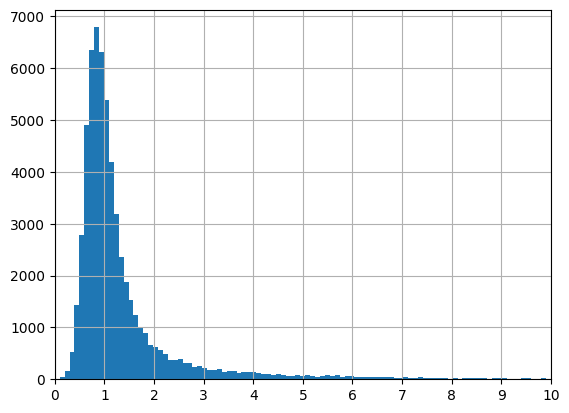

In [28]:
baseline_sCr[baseline_sCr['valuenum']<10].valuenum.hist(bins=100)
plt.xticks(np.arange(11))
plt.xlim(0,10)
plt.show()

## labtest duration

In [74]:
tmp = pd.concat([chartevents_SCr.shift(1),chartevents_SCr],axis=1)

In [75]:
tmp.columns = ['stay_id_x','charttime_x','valuenum_x','stay_id_y','charttime_y','valuenum_y']

In [76]:
tmp

,stay_id_x,charttime_x,valuenum_x,stay_id_y,charttime_y,valuenum_y
0,NaN,NaT,NaN,30000153,2174-09-29 15:37:00,0.9
1,30000153.0,2174-09-29 15:37:00,0.9,30000153,2174-09-30 03:34:00,1.1
2,30000153.0,2174-09-30 03:34:00,1.1,30000213,2162-06-21 14:02:00,3.7
3,30000213.0,2162-06-21 14:02:00,3.7,30000213,2162-06-21 20:43:00,3.7
4,30000213.0,2162-06-21 20:43:00,3.7,30000213,2162-06-22 04:00:00,3.6
...,...,...,...,...,...,...
425251,39999562.0,2129-01-28 08:40:00,0.9,39999810,2115-12-01 06:05:00,0.9
425252,39999810.0,2115-12-01 06:05:00,0.9,39999810,2115-12-01 13:15:00,0.9
425253,39999810.0,2115-12-01 13:15:00,0.9,39999810,2115-12-02 06:38:00,1.1
425254,39999810.0,2115-12-02 06:38:00,1.1,39999810,2115-12-03 06:25:00,1.1


In [77]:
tmp = tmp[tmp['stay_id_x'] == tmp['stay_id_y']]
tmp['timediff'] = tmp['charttime_y'] - tmp['charttime_x']

In [89]:
tmp2 = pd.DataFrame(tmp.timediff.value_counts().sort_index())

In [96]:
tmp['timediff_days'] = tmp.timediff.dt.total_seconds()/(60*60*24)

/var/folders/wb/hsgyhgm57kbgysv0zmm8fjgc0000gn/T/ipykernel_40266/317423249.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['timediff_days'] = tmp.timediff.dt.total_seconds()/(60*60*24)


<AxesSubplot:>

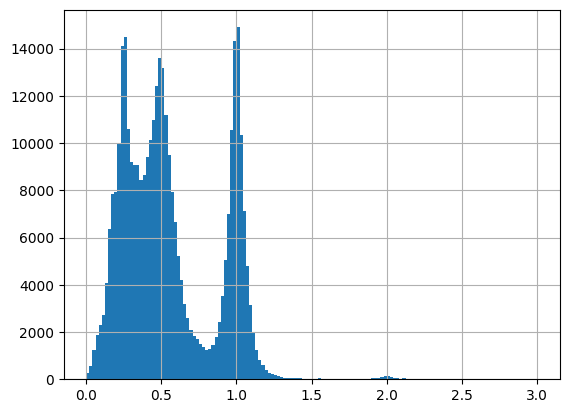

In [106]:
tmp[tmp['timediff_days']<3].timediff_days.hist(bins=144)

In [103]:
tmp.timediff_days.value_counts().sort_index()

timediff_days
0.000000       1
0.000694      30
0.001389      13
0.002083      10
0.002778       9
              ..
17.489583      1
18.343750      1
19.809028      1
33.224306      1
163.034028     1
Name: count, Length: 3418, dtype: int64

# Antibiotics

In [7]:
d_antibiotics = d_items[d_items['category']=='Antibiotics']
count = inputevents[inputevents['itemid'].isin(d_antibiotics.itemid)].itemid.value_counts()
antibiotics = pd.merge(d_antibiotics,count,on='itemid',how='left')
antibiotics[['label','itemid','count']].sort_values('count',ascending=False)

,label,itemid,count
0,Vancomycin,225798,122649.0
11,Cefepime,225851,61582.0
39,Piperacillin/Tazobactam (Zosyn),225893,60647.0
32,Metronidazole,225884,56718.0
10,Cefazolin,225850,38994.0
31,Meropenem,225883,38172.0
13,Ceftriaxone,225855,17725.0
15,Ciprofloxacin,225859,17278.0
35,Nafcillin,225888,11532.0
38,Piperacillin,225892,10892.0


In [9]:
antibiotics = inputevents[inputevents['itemid'].isin(d_antibiotics.itemid)]

In [10]:
antibiotics['starttime'] = pd.to_datetime(antibiotics['starttime'])

C:\Users\DAHS\AppData\Local\Temp\ipykernel_93372\2853088688.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  antibiotics['starttime'] = pd.to_datetime(antibiotics['starttime'])


In [11]:
antibiotics.reset_index(drop=True,inplace=True)

In [12]:
tmp = antibiotics[['stay_id','starttime']]

In [13]:
tmp.sort_values(['stay_id','starttime'],inplace=True)

C:\Users\DAHS\AppData\Local\Temp\ipykernel_93372\2205098246.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp.sort_values(['stay_id','starttime'],inplace=True)


In [14]:
tmp = pd.concat([tmp.shift(1),tmp],axis=1)

In [15]:
tmp.columns = ['stay_id_x','charttime_x','stay_id_y','charttime_y']

In [16]:
tmp = tmp[tmp['stay_id_x'] == tmp['stay_id_y']]
tmp['timediff'] = tmp['charttime_y'] - tmp['charttime_x']

In [17]:
tmp['timediff_days'] = tmp.timediff.dt.total_seconds()/(60*60*24)

In [18]:
tmp[tmp['timediff_days']!=0].timediff_days.describe()

count    467716.000000
mean          0.283278
std           0.466740
min           0.000694
25%           0.096528
50%           0.218750
75%           0.333333
max          45.527778
Name: timediff_days, dtype: float64

In [21]:
tmp['timediff_hours'] = tmp['timediff_days']*24

In [24]:
tmp['timediff_min'] = tmp['timediff_hours']*60

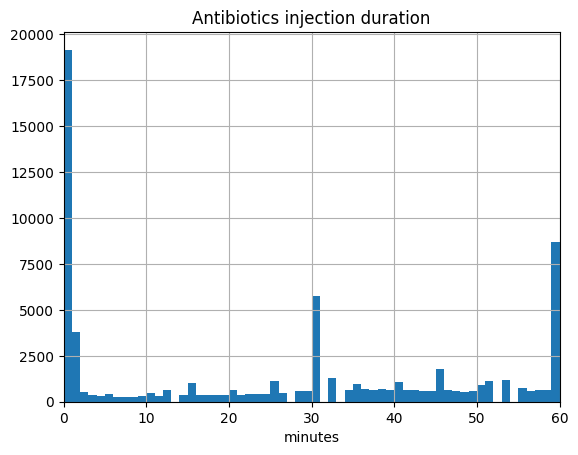

In [33]:
tmp[tmp['timediff_hours']<=1].timediff_min.hist(bins=60)
plt.xlim(0,60)
plt.xlabel('minutes')
plt.title('Antibiotics injection duration')
plt.show()

## Vancomycin

In [12]:
chartevents[chartevents['itemid'].isin([227453,227454,227455])].itemid.value_counts()

itemid
227455    17694
227454    15573
227453       14
Name: count, dtype: int64

In [10]:
#227453-Peak 227454-Random 227455-Trough
chartevents[chartevents['itemid'].isin([227453,227454,227455])]

,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning
141699,10004235,24181354,34100191,NaN,2196-02-25 06:11:00,2196-02-25 07:02:00,227455,10,10.0,ug/mL,0.0
141898,10004235,24181354,34100191,NaN,2196-02-26 16:30:00,2196-02-26 17:28:00,227454,10.4,10.4,ug/mL,0.0
147685,10004401,22869003,38292466,NaN,2144-04-06 08:03:00,2144-04-06 09:56:00,227455,7.5,7.5,ug/mL,1.0
147723,10004401,22869003,38292466,NaN,2144-04-07 02:57:00,2144-04-07 11:56:00,227454,14.7,14.7,ug/mL,0.0
147757,10004401,22869003,38292466,NaN,2144-04-08 05:59:00,2144-04-08 06:49:00,227455,31.4,31.4,ug/mL,1.0
...,...,...,...,...,...,...,...,...,...,...,...
313575591,19998330,24492004,32641669,NaN,2178-10-03 05:10:00,2178-10-03 06:52:00,227454,8.5,8.5,ug/mL,1.0
313584814,19998591,24349193,31144045,NaN,2185-07-22 04:53:00,2185-07-22 14:36:00,227454,11.3,11.3,ug/mL,0.0
313615433,19999287,20175828,35165301,NaN,2197-08-05 17:55:00,2197-08-05 19:17:00,227454,12.8,12.8,ug/mL,0.0
313615513,19999287,20175828,35165301,NaN,2197-08-08 06:15:00,2197-08-08 08:09:00,227454,18.8,18.8,ug/mL,0.0


In [11]:
# Vancomycin input events
vancomycin = inputevents[inputevents['itemid'].isin([225798])]

In [46]:
vancomycin.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'caregiver_id', 'starttime',
       'endtime', 'storetime', 'itemid', 'amount', 'amountuom', 'rate',
       'rateuom', 'orderid', 'linkorderid', 'ordercategoryname',
       'secondaryordercategoryname', 'ordercomponenttypedescription',
       'ordercategorydescription', 'patientweight', 'totalamount',
       'totalamountuom', 'isopenbag', 'continueinnextdept',
       'statusdescription', 'originalamount', 'originalrate'],
      dtype='object')

In [49]:
vancomycin['amount'].value_counts()

amount
1.000000       119415
1500.000119       866
1000.000000       617
1250.000000       600
750.000060        466
500.000000        302
1.500000           80
125.000000         57
1500.000000        54
2000.000000        45
250.000000         39
1750.000119        36
750.000000         15
2.000000           13
0.500000           12
0.000000            7
0.200000            4
200.000000          2
1.200000            2
1.200000            2
200.000003          2
8.000000            2
1.000000            1
1259.000063         1
100.000001          1
700.000048          1
10.000001           1
750.000007          1
15.000001           1
500.000024          1
1200.000048         1
150.000006          1
900.000036          1
Name: count, dtype: int64

In [13]:
len(vancomycin.stay_id.unique())

26763

In [29]:
# Dopamine
inputevents[inputevents['itemid'].isin([221662])]

,subject_id,hadm_id,stay_id,caregiver_id,starttime,endtime,storetime,itemid,amount,amountuom,...,ordercomponenttypedescription,ordercategorydescription,patientweight,totalamount,totalamountuom,isopenbag,continueinnextdept,statusdescription,originalamount,originalrate
198,10001884,26184834,37510196,47220,2131-01-11 07:40:00,2131-01-11 08:17:00,2131-01-11 08:30:00,221662,19.259530,mg,...,Main order parameter,Continuous Med,65.0,250.0,ml,0,0,ChangeDose/Rate,334.178864,8.0
210,10001884,26184834,37510196,47220,2131-01-11 08:17:00,2131-01-11 09:14:00,2131-01-11 08:30:00,221662,22.243373,mg,...,Main order parameter,Continuous Med,65.0,250.0,ml,0,0,ChangeDose/Rate,314.919342,6.0
212,10001884,26184834,37510196,47220,2131-01-11 09:14:00,2131-01-11 10:01:00,2131-01-11 09:35:00,221662,6.113676,mg,...,Main order parameter,Continuous Med,65.0,250.0,ml,0,0,Paused,292.675964,2.0
249,10001884,26184834,37510196,64480,2131-01-11 04:50:00,2131-01-11 05:04:00,2131-01-11 04:50:00,221662,9.105691,mg,...,Main order parameter,Continuous Med,65.0,250.0,ml,0,0,ChangeDose/Rate,400.000000,10.0
254,10001884,26184834,37510196,64480,2131-01-11 05:04:00,2131-01-11 06:54:00,2131-01-11 05:04:00,221662,35.772359,mg,...,Main order parameter,Continuous Med,65.0,250.0,ml,0,0,ChangeDose/Rate,390.894318,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8974078,19997293,20208898,31629173,72391,2123-10-15 01:45:00,2123-10-15 01:55:00,2123-10-15 02:16:00,221662,3.364172,mg,...,Main order parameter,Continuous Med,134.5,250.0,ml,0,0,ChangeDose/Rate,400.000000,2.5
8974083,19997293,20208898,31629173,72391,2123-10-15 01:55:00,2123-10-15 02:00:00,2123-10-15 02:17:00,221662,2.355320,mg,...,Main order parameter,Continuous Med,134.5,250.0,ml,0,0,Paused,396.635834,3.5
8976232,19997473,27787494,32134105,24834,2173-09-18 23:00:00,2173-09-18 23:10:00,2173-09-18 23:09:00,221662,9.478673,mg,...,Main order parameter,Continuous Med,63.1,250.0,ml,0,0,ChangeDose/Rate,400.000000,15.0
8976234,19997473,27787494,32134105,24834,2173-09-18 23:10:00,2173-09-18 23:15:00,2173-09-18 23:10:00,221662,3.159558,mg,...,Main order parameter,Continuous Med,63.1,250.0,ml,0,0,ChangeDose/Rate,390.521332,10.0


In [30]:
# Dobutamine
inputevents[inputevents['itemid'].isin([221653])]

,subject_id,hadm_id,stay_id,caregiver_id,starttime,endtime,storetime,itemid,amount,amountuom,...,ordercomponenttypedescription,ordercategorydescription,patientweight,totalamount,totalamountuom,isopenbag,continueinnextdept,statusdescription,originalamount,originalrate
24575,10022620,27180902,31953583,16723,2174-01-04 20:50:00,2174-01-05 14:08:00,2174-01-05 14:09:00,221653,145.498015,mg,...,Main order parameter,Continuous Med,56.0,250.0,ml,0,0,FinishedRunning,145.498001,2.500659
24603,10022620,27180902,31953583,25610,2174-01-04 14:38:00,2174-01-04 20:50:00,2174-01-04 14:50:00,221653,104.201685,mg,...,Main order parameter,Continuous Med,56.0,250.0,ml,0,0,ChangeDose/Rate,250.000000,5.000000
24613,10022620,27180902,31953583,25610,2174-01-05 14:08:00,2174-01-05 14:50:00,2174-01-05 14:09:00,221653,5.885651,mg,...,Main order parameter,Continuous Med,56.0,250.0,ml,0,0,Stopped,250.000000,2.500000
24694,10022620,27180902,31953583,55302,2174-01-03 23:51:00,2174-01-04 14:38:00,2174-01-04 14:50:00,221653,248.500002,mg,...,Main order parameter,Continuous Med,56.0,250.0,ml,0,0,FinishedRunning,248.500000,5.003593
24734,10022620,27180902,31953583,58657,2174-01-03 12:27:00,2174-01-03 14:00:00,2174-01-03 12:27:00,221653,13.025211,mg,...,Main order parameter,Continuous Med,56.0,250.0,ml,0,0,ChangeDose/Rate,250.000000,2.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8947554,19968075,28592225,31756531,24834,2153-04-22 23:44:00,2153-04-23 07:31:00,2153-04-23 07:29:00,221653,191.709037,mg,...,Main order parameter,Continuous Med,102.6,250.0,ml,0,0,FinishedRunning,191.709000,4.000431
8947592,19968075,28592225,31756531,24834,2153-04-23 07:31:00,2153-04-23 13:25:00,2153-04-23 07:29:00,221653,145.305547,mg,...,Main order parameter,Continuous Med,102.6,250.0,ml,0,0,ChangeDose/Rate,250.000000,4.000000
8969293,19990821,27777812,38906628,94919,2143-03-07 02:11:00,2143-03-07 02:34:00,2143-03-07 02:11:00,221653,7.133995,mg,...,Main order parameter,Continuous Med,62.0,250.0,ml,0,0,ChangeDose/Rate,250.000000,5.000000
8969297,19990821,27777812,38906628,94919,2143-03-07 02:34:00,2143-03-07 02:35:00,2143-03-07 02:34:00,221653,0.496658,mg,...,Main order parameter,Continuous Med,62.0,250.0,ml,0,0,ChangeDose/Rate,242.866013,8.000001


In [31]:
# Epinephrine
inputevents[inputevents['itemid'].isin([221289])]

,subject_id,hadm_id,stay_id,caregiver_id,starttime,endtime,storetime,itemid,amount,amountuom,...,ordercomponenttypedescription,ordercategorydescription,patientweight,totalamount,totalamountuom,isopenbag,continueinnextdept,statusdescription,originalamount,originalrate
1620,10002760,28094813,31831386,48770,2141-04-20 14:30:00,2141-04-21 00:30:00,2141-04-20 15:02:00,221289,1.092896,mg,...,Main order parameter,Continuous Med,91.0,250.0,ml,0,0,ChangeDose/Rate,2.000000,0.020000
1667,10002760,28094813,31831386,85199,2141-04-21 00:30:00,2141-04-21 06:49:00,2141-04-21 01:50:00,221289,0.345173,mg,...,Main order parameter,Continuous Med,91.0,250.0,ml,0,0,Stopped,0.907104,0.010000
2810,10004235,24181354,34100191,15977,2196-02-24 17:30:00,2196-02-24 17:52:00,2196-02-24 17:50:00,221289,0.280255,mg,...,Main order parameter,Continuous Med,127.0,250.0,ml,0,0,Stopped,2.000000,0.100000
8155,10007818,22987108,32359580,25842,2146-06-22 12:49:00,2146-06-22 12:54:00,2146-06-22 12:49:00,221289,0.034483,mg,...,Main order parameter,Continuous Med,86.2,250.0,ml,0,0,ChangeDose/Rate,2.000000,0.080000
8157,10007818,22987108,32359580,25842,2146-06-22 12:54:00,2146-06-22 12:56:00,2146-06-22 12:54:00,221289,0.017241,mg,...,Main order parameter,Continuous Med,86.2,250.0,ml,0,0,ChangeDose/Rate,1.965517,0.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8975571,19997367,20617667,35616526,80500,2126-04-23 00:31:00,2126-04-23 14:37:00,2126-04-23 15:01:00,221289,2.000000,mg,...,Main order parameter,Continuous Med,59.0,250.0,ml,0,0,FinishedRunning,2.000000,0.040071
8975747,19997367,20617667,35616526,85321,2126-04-23 23:01:00,2126-04-24 01:02:00,2126-04-23 23:03:00,221289,0.213878,mg,...,Main order parameter,Continuous Med,59.0,250.0,ml,0,0,ChangeDose/Rate,0.811321,0.030000
8975751,19997367,20617667,35616526,85321,2126-04-24 01:02:00,2126-04-24 09:29:00,2126-04-24 11:29:00,221289,0.597000,mg,...,Main order parameter,Continuous Med,59.0,250.0,ml,0,0,FinishedRunning,0.597000,0.019985
8975801,19997367,20617667,35616526,87605,2126-04-21 11:42:00,2126-04-21 21:10:00,2126-04-21 11:42:00,221289,0.988686,mg,...,Main order parameter,Continuous Med,58.0,250.0,ml,0,0,ChangeDose/Rate,2.000000,0.030000


In [33]:
chartevents[chartevents['itemid'].isin([220739, 223900, 223901])]

,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning
34,10000032,29079034,39553978,66056.0,2180-07-23 20:00:00,2180-07-23 21:13:00,220739,Spontaneously,4.0,None,0.0
36,10000032,29079034,39553978,66056.0,2180-07-23 20:00:00,2180-07-23 21:13:00,223900,Oriented,5.0,None,0.0
37,10000032,29079034,39553978,66056.0,2180-07-23 20:00:00,2180-07-23 21:13:00,223901,Obeys Commands,6.0,None,0.0
265,10000032,29079034,39553978,88981.0,2180-07-23 14:45:00,2180-07-23 14:46:00,220739,Spontaneously,4.0,None,0.0
266,10000032,29079034,39553978,88981.0,2180-07-23 14:45:00,2180-07-23 14:46:00,223901,Obeys Commands,6.0,None,0.0
...,...,...,...,...,...,...,...,...,...,...,...
313644689,19999987,23865745,36195440,86756.0,2145-11-03 06:00:00,2145-11-03 06:05:00,223900,No Response-ETT,1.0,None,0.0
313644690,19999987,23865745,36195440,86756.0,2145-11-03 06:00:00,2145-11-03 06:05:00,223901,Localizes Pain,5.0,None,0.0
313644885,19999987,23865745,36195440,91879.0,2145-11-04 20:00:00,2145-11-04 20:50:00,220739,Spontaneously,4.0,None,0.0
313644886,19999987,23865745,36195440,91879.0,2145-11-04 20:00:00,2145-11-04 20:50:00,223900,Confused,4.0,None,0.0


In [9]:
d_items.linksto.value_counts()

linksto
chartevents         2982
inputevents          474
datetimeevents       188
procedureevents      169
ingredientevents     124
outputevents          77
Name: count, dtype: int64

In [16]:
antibiotics.itemid.unique()

array([225798, 225837, 225838, 225840, 225842, 225843, 225844, 225845,
       225847, 225848, 225850, 225851, 225853, 225855, 225857, 225859,
       225860, 225862, 225863, 225865, 225866, 225868, 225869, 225871,
       225873, 225875, 225876, 225877, 225879, 225881, 225882, 225883,
       225884, 225885, 225886, 225888, 225889, 225890, 225892, 225893,
       225895, 225896, 225897, 225898, 225899, 225900, 225902, 225903,
       225905, 227691, 228003, 229059, 229061, 229064, 229587])

In [21]:
inputevents_antibiotics = inputevents[inputevents['itemid'].isin(antibiotics.itemid.unique())]

In [23]:
inputevents_antibiotics = inputevents_antibiotics[['stay_id','itemid']]

In [25]:
inputevents_antibiotics.drop_duplicates(inplace=True)

/var/folders/wb/hsgyhgm57kbgysv0zmm8fjgc0000gn/T/ipykernel_45841/3383051277.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inputevents_antibiotics.drop_duplicates(inplace=True)


In [27]:
inputevents_antibiotics['count'] = 1

/var/folders/wb/hsgyhgm57kbgysv0zmm8fjgc0000gn/T/ipykernel_45841/2994366333.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inputevents_antibiotics['count'] = 1


In [36]:
sum_count = inputevents_antibiotics.groupby('stay_id')['count'].sum()

In [44]:
inputevents_antibiotics.groupby('itemid')['count'].sum().sort_values(ascending=False)

itemid
225798    26763
225850    11651
225851    11265
225893     8420
225884     8032
225855     7608
225859     4336
225883     3767
225892     3081
225879     2665
225845     2345
225853     1965
225837     1621
225842     1456
225843     1390
225869     1351
225860     1116
225881     1112
225885     1083
225899      912
225875      841
225863      767
225902      648
225888      642
225847      485
225865      305
225905      288
225866      275
225838      186
225876      166
225890      137
225840      111
228003      109
225873       98
225898       91
227691       78
225844       77
225848       67
225903       62
229064       50
229587       40
225862       35
229061       17
225871       12
225877        9
225896        8
225886        8
225868        7
225895        4
Name: count, dtype: int64

In [51]:
sum_count.value_counts()

count
1     15300
2     12921
3      7775
4      4372
5      2130
6      1062
7       549
8       257
9       140
10       68
11       31
12       15
13        7
14        6
16        2
18        1
Name: count, dtype: int64

In [54]:
len(chartevents.stay_id.unique())-sum_count.value_counts().sum()

28540

: 

In [39]:
inputevents_antibiotics

,stay_id,itemid,count
6,39765666,225851,1
8,39765666,225798,1
10,39765666,225855,1
12,39765666,225879,1
24,37067082,225798,1
...,...,...,...
8978488,38978960,225855,1
8978512,38978960,225842,1
8978516,38978960,225837,1
8978543,38978960,225843,1


# Suspected infection

In [ ]:
icd9_suspected_infection = ['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', 
                           '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', 
                           '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', 
                           '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', 
                           '041', '042', '043', '044', '045', '046', '047', '048', '049', '050', 
                           '051', '052', '053', '054', '055', '056', '057', '058', '059', '060', 
                           '061', '062', '063', '064', '065', '066', '067', '068', '069', '070', 
                           '071', '072', '073', '074', '075', '076', '077', '078', '079', '080', 
                           '081', '082', '083', '084', '085', '086', '087', '088', '089', '090', 
                           '091', '092', '093', '094', '095', '096', '097', '098', '099', '100', 
                           '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', 
                           '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', 
                           '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', 
                           '131', '132', '133', '134', '135', '136', '137', '138', '139', '320', 
                           '321', '322', '323', '324', '325', '326', '42090', '420', '421', '422', 
                           '4476', '460', '461', '462', '463', '464', '465', '482', '483', '484', 
                           '485', '486', '487', '488', '466', '523', '52800', '5283', '6820', '53110', 
                           '53120', '53160', '53210', '53220', '53250', '53410', '53420', '53450', 
                           '542', '541', '562', '566', '5695', '56983', '567', '99859', '572', 
                           '5740', '5741', '5742', '5743', '5744', '5745', '5746', '5747', '5748', 
                           '5750', '5751', '5754', '5759', '5761', '5763', '681', '682', '683', 
                           '684', '685', '686', '711', '590', '595', '597', '5990', '601', '604', 
                           '608', '611', '614', '615', '616', '646', '670', '647', '675', '672', 
                           '7806', '7806', '78559', '7855', '99592', '78552', '7919', '7920', '7929', 
                           '7924', '7922', '7929', '7907']

In [ ]:
icd10_suspected_infection = ['A', 'B', 'G00', 'G01', 'G02', 'G03', 'G04', 'G05', 'G06', 'G07', 'G08',
                              'G09', 'I30', 'I32', 'I33', 'I40', 'I776', 'J00', 'J01', 'J02', 'J03', 
                              'J04', 'J05', 'J06', 'J09', 'J10', 'J11', 'J12', 'J13', 'J14', 'J15', 
                              'J16', 'J17', 'J18', 'J20', 'J21', 'J22', 'K05', 'K122', 'K251', 'K252', 
                              'K256', 'K261', 'K262', 'K265', 'K281', 'K282', 'K285', 'K35', 'K36', 'K37', 
                              'K57', 'K61', 'K630', 'K631', 'K65', 'K681', 'K750', 'K800', 'K801', 'K803', 
                              'K804', 'K806', 'K81', 'K822', 'K82A', 'K830', 'K832', 'L00', 'L01', 'L02', 
                              'L03', 'L04', 'L05', 'L06', 'L07', 'L08', 'M00', 'M01', 'M02', 'N10', 'N30', 
                              'N34', 'N390', 'N41', 'N45', 'N49', 'N61', 'N70', 'N71', 'N72', 'N73', 'N74', 
                              'N75', 'N76', 'N77', 'O23', 'O85', 'O86', 'O91', 'O98', 'R508', 'R509', 'R578', 
                              'R579', 'R652', 'R827', 'R835', 'R845', 'R855', 'R865', 'R875', 'R7881']

In [ ]:
prescription_antibiotics = ['amikacin', 'gentamicin', 'kanamycin', 'netilmicin', 'tobramycin', 'paromomycin', 'spectinomycin', 'geldanamycin', 
                            'ertapenem', 'doripenem', 'imipenem', 'meropenem', 'cefadroxil', 'cefalexin', 'cefaclor', 'cefoxitin', 'cefprozil', 
                            'cefamandole', 'cefuroxime', 'cefixime', 'cefotaxime', 'cefpodoxime', 'ceftazidime', 'ceftriaxone', 'cefepime', 'vancomycin', 
                            'vanc', 'clindamycin', 'daptomycin', 'azithromycin', 'clarithromycin', 'erythromycin', 'telithromycin', 'aztreonam', 
                            'nitrofurantoin', 'linezolid', 'amoxicillin', 'ampicillin', 'dicloxacillin', 'flucloxacillin', 'methicillin', 'nafcillin', 
                            'oxacillin', 'penicillin', 'piperacillin', 'cefotetan', 'ticarcillin', 'timentin', 'colistin', 'bactrim', 'polymyxin', 
                            'ciprofloxacin', 'gatifloxacin', 'levofloxacin', 'moxifloxacin', 'nalidixic acid', 'norfloxacin', 'ofloxacin', 'trovafloxacin', 
                            'sulfadiazine', 'sulfamethoxazole', 'trimethoprim', 'TMP', 'doxycycline', 'minocycline', 'tetracycline', 'dapsone', 'ethambutol', 
                            'isoniazid', 'pyrazinamide', 'rifampicin', 'rifampin', 'rifabutin', 'streptomycin', 'chloramphenicol', 'synercid', 'fosfomycin', 
                            'metronidazole', 'mupirocin', 'quinupristin', 'tigecycline', 'unasyn']

In [ ]:
d_antibiotics = d_items[(d_items['linksto']=='inputevents')&(d_items['category']=='Antibiotics')].itemid.unique()

diagnoses_icd9  = diagnoses_icd[diagnoses_icd['icd_version']==9]
diagnoses_icd10 = diagnoses_icd[diagnoses_icd['icd_version']==10]

In [ ]:
# Suspected infection with ICD9 code
SI_icd9 = diagnoses_icd9[diagnoses_icd9['icd_code'].str.startswith(tuple(icd9_suspected_infection))].hadm_id.unique()

# Suspected infection with ICD10 code
SI_icd10 = diagnoses_icd10[diagnoses_icd10['icd_code'].str.startswith(tuple(icd10_suspected_infection))].hadm_id.unique()

#Blood culture - icu
SI_BC_icu = procedureevents[procedureevents['itemid'].isin([225401,225437])].hadm_id.unique()

#Blood culture - hosp
SI_BC_hosp = microbiology[microbiology['spec_itemid'].isin([70011,70012])].hadm_id.unique()

#Prescription - icu
prescriptions['drug'] = prescriptions['drug'].str.lower()
SI_AB_hosp = prescriptions[prescriptions['drug'].isin(prescription_antibiotics)].hadm_id.unique()

SI_AB_icu = inputevents[inputevents['itemid'].isin(d_antibiotics)].hadm_id.unique()

In [ ]:
SI_icd = np.unique(np.concatenate([SI_icd9,SI_icd10]))
SI_AB  = np.unique(np.concatenate([SI_AB_hosp,SI_AB_icu]))
SI_BC  = np.unique(np.concatenate([SI_BC_hosp,SI_BC_icu]))

hadm_id = np.unique(np.concatenate([SI_icd, SI_AB, SI_BC]))

In [ ]:
# ICD code
print("ICD code : ", len(icustays[icustays['hadm_id'].isin(SI_icd)]))

# Antibiotics
print("\nAntibiotics in Hosp : ", len(icustays[icustays['hadm_id'].isin(SI_AB_hosp)]))
print("Antibiotics in ICU  : ", len(icustays[icustays['hadm_id'].isin(SI_AB_icu)]))
print("Antibiotics All     : ", len(icustays[icustays['hadm_id'].isin(SI_AB)]))

# Blood Culture
print("\nBlood culture in Hosp : ", len(icustays[icustays['hadm_id'].isin(SI_BC_hosp)]))
print("Blood culture in ICU  : ", len(icustays[icustays['hadm_id'].isin(SI_BC_icu)]))
print("Blood culture All     : ", len(icustays[icustays['hadm_id'].isin(SI_BC)]))

# Antibiotics & Blood Culture in ICU
print("-------------------------------------------")
print("AB & BC in ICU : ", len(icustays[(icustays['hadm_id'].isin(SI_AB_icu)) | (icustays['hadm_id'].isin(SI_BC_icu))]))

# All
print("-------------------------------------------")
print("All : ", len(icustays[icustays['hadm_id'].isin(hadm_id)]))

# Lab

In [8]:
d_labs = d_items[d_items['category']=='Labs']
d_labs_itemid = d_labs.itemid.unique()

chartevents_labs = chartevents[chartevents['itemid'].isin(d_labs_itemid)]

chartevents_labs['count'] = 1
chartevents_labs = chartevents_labs[['itemid','count']]

tmp = chartevents_labs.groupby(by='itemid')['count'].sum()
tmp = pd.DataFrame(tmp)
tmp.reset_index(inplace=True)

d_labs = pd.merge(d_labs,tmp,on='itemid',how='left')

d_labs = d_labs.dropna(subset=['count'])

In [28]:
d_labs

In [32]:
chartevents[chartevents['itemid'].isin([223848])].value.value_counts()

value
Drager                368975
Hamilton              195138
Avea                    6431
Other                   1217
BiPAP/CPAP               180
Respironics BiPAP         10
Sensor Medic (HFO)         9
PB 7200                    4
Name: count, dtype: int64

In [33]:
chartevents[chartevents['itemid'].isin([223849])].value.value_counts()

value
CPAP/PSV                  192510
CMV/ASSIST/AutoFlow       175435
CMV/ASSIST                 17945
MMV/PSV/AutoFlow           12726
Standby                    11044
PSV/SBT                     8550
PRVC/AC                     5029
PCV+Assist                  4152
CPAP/PSV+ApnVol             3410
SIMV/PSV/AutoFlow           1947
MMV/PSV                     1880
CPAP                        1243
APRV                        1046
CMV/AutoFlow                1030
CPAP/PPS                     948
CPAP/PSV+ApnPres             750
VOL/AC                       519
PCV+                         451
CMV                          430
PCV+/PSV                     395
PRES/AC                      320
SIMV/PSV                     310
APV (cmv)                    305
SPONT                        199
MMV                          189
Apnea Ventilation            127
APRV/Biphasic+ApnVol         105
MMV/AutoFlow                  67
APRV/Biphasic+ApnPress        34
SIMV/PRES                     31
PRVC

In [57]:
d_vitals = d_items[d_items['category']=='Routine Vital Signs']
d_vitals_itemid = d_vitals.itemid.unique()

chartevents_vitals = chartevents[chartevents['itemid'].isin(d_vitals_itemid)]

chartevents_vitals['count'] = 1
chartevents_vitals = chartevents_vitals[['itemid','count']]

tmp = chartevents_vitals.groupby(by='itemid')['count'].sum()
tmp = pd.DataFrame(tmp)
tmp.reset_index(inplace=True)

d_vitals = pd.merge(d_vitals,tmp,on='itemid',how='left')

d_vitals = d_vitals.dropna(subset=['count'])

C:\Users\DAHS\AppData\Local\Temp\ipykernel_32460\4271437571.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chartevents_vitals['count'] = 1


In [59]:
chartevents[chartevents['itemid'].isin([225312,225309])]

,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning
19188,10002013,23581541,39060235,6768.0,2160-05-18 20:00:00,2160-05-18 21:16:00,225309,132,132.0,mmHg,0.0
19190,10002013,23581541,39060235,6768.0,2160-05-18 20:00:00,2160-05-18 21:16:00,225312,85,85.0,mmHg,0.0
19333,10002013,23581541,39060235,6768.0,2160-05-18 21:00:00,2160-05-18 21:16:00,225309,94,94.0,mmHg,0.0
19335,10002013,23581541,39060235,6768.0,2160-05-18 21:00:00,2160-05-18 21:16:00,225312,68,68.0,mmHg,0.0
19362,10002013,23581541,39060235,6768.0,2160-05-18 22:00:00,2160-05-18 22:08:00,225309,133,133.0,mmHg,0.0
...,...,...,...,...,...,...,...,...,...,...,...
313452288,19995595,21784060,34670930,77293.0,2126-10-21 21:00:00,2126-10-21 21:18:00,225312,62,62.0,mmHg,0.0
313452314,19995595,21784060,34670930,77293.0,2126-10-21 23:00:00,2126-10-21 23:02:00,225309,126,126.0,mmHg,0.0
313452316,19995595,21784060,34670930,77293.0,2126-10-21 23:00:00,2126-10-21 23:02:00,225312,71,71.0,mmHg,0.0
313452320,19995595,21784060,34670930,77293.0,2126-10-22 05:00:00,2126-10-22 05:12:00,225309,125,125.0,mmHg,0.0


In [60]:
chartevents[chartevents['itemid'].isin([220074])]

,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning
19191,10002013,23581541,39060235,6768.0,2160-05-18 20:00:00,2160-05-18 21:17:00,220074,17,17.0,mmHg,0.0
19336,10002013,23581541,39060235,6768.0,2160-05-18 21:00:00,2160-05-18 21:17:00,220074,11,11.0,mmHg,0.0
19356,10002013,23581541,39060235,6768.0,2160-05-18 22:00:00,2160-05-18 22:08:00,220074,12,12.0,mmHg,0.0
19391,10002013,23581541,39060235,6768.0,2160-05-18 23:00:00,2160-05-18 23:01:00,220074,10,10.0,mmHg,0.0
19409,10002013,23581541,39060235,6768.0,2160-05-19 00:00:00,2160-05-19 00:05:00,220074,9,9.0,mmHg,0.0
...,...,...,...,...,...,...,...,...,...,...,...
313640607,19999840,21033226,38978960,54944.0,2164-09-15 01:00:00,2164-09-15 01:05:00,220074,10,10.0,mmHg,0.0
313640615,19999840,21033226,38978960,54944.0,2164-09-15 01:05:00,2164-09-15 01:23:00,220074,10,10.0,mmHg,0.0
313640622,19999840,21033226,38978960,54944.0,2164-09-15 01:10:00,2164-09-15 01:23:00,220074,10,10.0,mmHg,0.0
313640629,19999840,21033226,38978960,54944.0,2164-09-15 01:15:00,2164-09-15 01:23:00,220074,9,9.0,mmHg,0.0


In [64]:
category = pd.DataFrame(d_items.category.value_counts())

In [66]:
category.reset_index(inplace=True)

<Axes: >

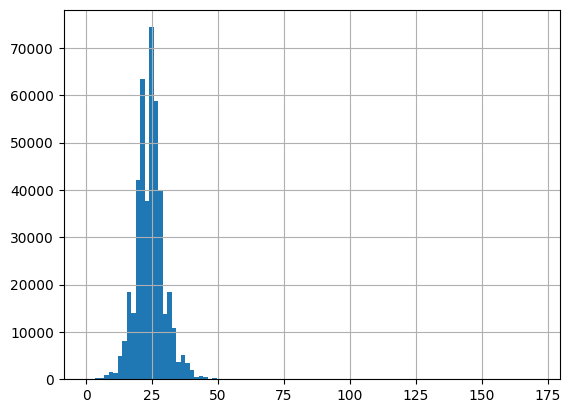

In [83]:
tmp = chartevents[chartevents['itemid'].isin([227443])]

tmp[tmp['valuenum']<1000].valuenum.hist(bins=100)

In [86]:
tmp = chartevents[chartevents['itemid'].isin([224828])]

In [1]:
tmp[(tmp['valuenum']<=100) & (tmp['valuenum'] >= -100)].valuenum.hist(bins = 201)

NameError: name 'tmp' is not defined

In [104]:
tmp.valueuom.unique()

array(['mg/dL', None], dtype=object)

<Axes: >

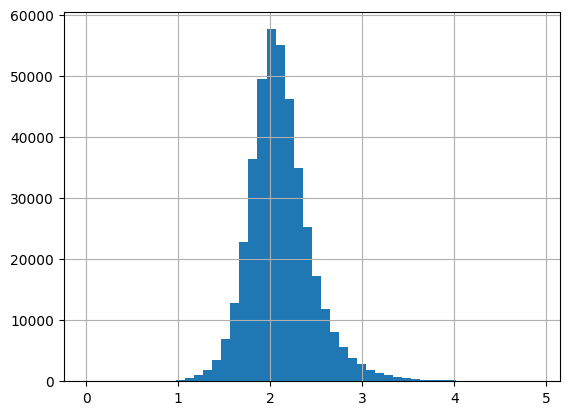

In [102]:
#magnesium
tmp = chartevents[chartevents['itemid'].isin([220635])]
tmp[tmp['valuenum']<5].valuenum.hist(bins=50)

In [96]:

chartevents[chartevents['itemid'].isin([227466])]

,subject_id,hadm_id,stay_id,caregiver_id,charttime,storetime,itemid,value,valuenum,valueuom,warning
2300,10001217,24597018,37067082,NaN,2157-11-21 03:16:00,2157-11-21 04:47:00,227466,33.1,33.1,sec,0.0
3547,10001217,27703517,34592300,NaN,2157-12-20 01:45:00,2157-12-20 02:17:00,227466,32.3,32.3,sec,0.0
4613,10001725,25563031,31205490,NaN,2110-04-11 18:02:00,2110-04-11 18:46:00,227466,31.8,31.8,sec,0.0
4631,10001725,25563031,31205490,NaN,2110-04-12 02:59:00,2110-04-12 03:45:00,227466,29.4,29.4,sec,0.0
18763,10001884,26184834,37510196,NaN,2131-01-11 06:31:00,2131-01-11 07:39:00,227466,21.3,21.3,sec,1.0
...,...,...,...,...,...,...,...,...,...,...,...
313633769,19999625,25304202,31070865,NaN,2139-10-11 04:21:00,2139-10-11 05:12:00,227466,31,31.0,sec,0.0
313635281,19999828,25744818,36075953,NaN,2149-01-09 03:13:00,2149-01-09 04:38:00,227466,20.7,20.7,sec,1.0
313635322,19999828,25744818,36075953,NaN,2149-01-10 05:58:00,2149-01-10 06:44:00,227466,24,24.0,sec,1.0
313642096,19999840,21033226,38978960,NaN,2164-09-13 01:51:00,2164-09-13 03:13:00,227466,29.3,29.3,sec,0.0
